In [757]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [241]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [245]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """

        # Your code goes here. ################################################
        self.output = input
        for module in self.modules:
            self.output = module.forward(self.output)
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        outputs = [input]
        for i in range(len(self.modules)):
            outputs.append(self.modules[i].forward(outputs[-1]))
        current_grad = gradOutput
        for i in range(len(self.modules)-1, -1, -1):
            current_grad = self.modules[i].backward(outputs[i], current_grad)
        self.gradInput = current_grad
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [631]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        # self.input = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # self.input = input
        # print(input.shape, self.W.T.shape) - Было нужно для отладки, можно удалить
        self.output = input @ self.W.T + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradW += gradOutput.T @ input
        self.gradb += gradOutput.sum(axis=0)
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [252]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        self.output = np.exp(self.output) / np.exp(self.output).sum(axis=1, keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.updateOutput(input)
        batch_size = input.shape[0]
        self.gradInput = np.zeros_like(input)
        for i in range(batch_size):
            s = self.output[i].reshape(-1, 1)
            grad = gradOutput[i].reshape(-1, 1)
            jacobian = np.diagflat(s) - s @ s.T
            self.gradInput[i] = (jacobian @ grad).flatten()
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [255]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        self.output = self.output - np.log(np.exp(self.output).sum(axis=1, keepdims=True))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.updateOutput(input)
        self.gradInput = gradOutput - np.exp(self.output) * gradOutput.sum(axis=1, keepdims=True)
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [258]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please
        if self.training:
            mean = np.mean(input, axis=0, keepdims=True)
            var = np.var(input, axis=0, keepdims=True)
            self.normalized = (input - mean) / np.sqrt(var + self.EPS)
            self.output = self.normalized
            if self.moving_mean is None:
                self.moving_mean = mean
                self.moving_variance = var
            else:
                self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
                self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
            self.current_mean = mean
            self.current_var = var
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)        
        return self.output


    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        if self.training:
            N = input.shape[0]  # Размер батча

            std = np.sqrt(self.current_var + self.EPS)
            x_centered = input - self.current_mean

            dnorm = gradOutput
    
            dvar = np.sum(dnorm * x_centered * -0.5 * (self.current_var + self.EPS)**(-1.5), axis=0)
            dmean = np.sum(dnorm * -1 / std, axis=0) + dvar * np.mean(-2 * x_centered, axis=0)
            self.gradInput = (dnorm / std) + (dvar * 2 * x_centered / N) + (dmean / N)
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"

In [260]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\3092293347.py:2: SyntaxWarning: invalid escape sequence '\g'
  """


Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [264]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        if self.training:
            keep_prob = 1.0 - self.p
            self.mask = (np.random.rand(*input.shape) < keep_prob).astype(np.float32)
            self.output = input * self.mask / keep_prob
        else:
            self.output = input.copy()
        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.training:
            self.gradInput = gradOutput * self.mask / (1.0 - self.p)
        else:
            self.gradInput = gradOutput.copy()
        return self.gradInput

    def __repr__(self):
        return "Dropout"

#6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [939]:
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride
        
        if padding == 'same':
            self.padding = (int((self.kernel_size[0] - 1) / 2), int((self.kernel_size[1] - 1) / 2))
        else:
            self.padding = (padding, padding) if isinstance(padding, int) else padding
            
        self.has_bias = bias
        self.padding_mode = padding_mode

        self.weight = np.random.randn(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        self.gradWeight = np.zeros_like(self.weight)
        
        if self.has_bias:
            self.bias = np.random.randn(out_channels)
            self.gradBias = np.zeros_like(self.bias)

        if self.padding_mode == 'zeros':
            self.pad_mode = 'constant'
            self.pad_value = 0
        elif self.padding_mode == 'replicate':
            self.pad_mode = 'edge'
        elif self.padding_mode == 'reflect':
            self.pad_mode = 'reflect'

    def updateOutput(self, input):
        batch_size = input.shape[0]
        H_in, W_in = input.shape[2], input.shape[3]

        H_out = int(np.floor((H_in + 2 * self.padding[0] - self.kernel_size[0]) / self.stride[0])) + 1
        W_out = int(np.floor((W_in + 2 * self.padding[1] - self.kernel_size[1]) / self.stride[1])) + 1

        self.output = np.zeros((batch_size, self.out_channels, H_out, W_out))

        if self.pad_mode == 'constant':
            self.input_pad = np.pad(
                input, 
                ((0, 0), (0, 0), 
                (self.padding[0], self.padding[0]), 
                (self.padding[1], self.padding[1])),
                mode=self.pad_mode, 
                constant_values=self.pad_value
            )
        else:
            self.input_pad = np.pad(
                input, 
                ((0, 0), (0, 0), 
                (self.padding[0], self.padding[0]), 
                (self.padding[1], self.padding[1])),
                mode=self.pad_mode
            )
            
        for n in range(batch_size):
            for c_out in range(self.out_channels):
                for h_out in range(H_out):
                    for w_out in range(W_out):
                        h_start = h_out * self.stride[0]
                        w_start = w_out * self.stride[1]

                        receptive_field = self.input_pad[
                            n, 
                            :, 
                            h_start:(h_start + self.kernel_size[0]), 
                            w_start:(w_start + self.kernel_size[1])
                        ]
                        
                        self.output[n, c_out, h_out, w_out] = np.sum(
                            receptive_field * self.weight[c_out]
                        )
                        
                        if self.has_bias:
                            self.output[n, c_out, h_out, w_out] += self.bias[c_out]
                            
        return self.output

    def updateGradInput(self, input, gradOutput):
        def edge_mode(row, col, input_height, input_width, padding):
            if row < padding[0]:
                original_row = 0
            elif row >= input_height + padding[0]:
                original_row = input_height - 1
            else:
                original_row = row - padding[0]
            if col < padding[1]:
                original_col = 0
            elif col >= input_width + padding[1]:
                original_col = input_width - 1
            else:
                original_col = col - padding[1]
            return original_row, original_col

        def reflect_mode(row, col, input_height, input_width, padding):
            original_row = row
            if row < 0:
                original_row = -row
            elif row >= input_height:
                original_row = 2 * (input_height - 1) - row

            original_col = col
            if col < 0:
                original_col = -col
            elif col >= input_width:
                original_col = 2 * (input_width - 1) - col
                
            return original_row, original_col

        H_in, W_in = input.shape[2], input.shape[3]
        batch_size, C_out, H_out, W_out = gradOutput.shape

        self.gradInput = np.zeros_like(input)
        for n in range(batch_size):
            for c_out in range(C_out):
                for h_out in range(H_out):
                    for w_out in range(W_out):
                        h_start = h_out * self.stride[0]
                        w_start = w_out * self.stride[1]

                        for c_in in range(self.in_channels):
                            for h_ker in range(self.kernel_size[0]):
                                for w_ker in range(self.kernel_size[1]):
                                    h_in = h_start + h_ker - self.padding[0]
                                    w_in = w_start + w_ker - self.padding[1]

                                    if (0 <= h_in < H_in) and (0 <= w_in < W_in):
                                        self.gradInput[n, c_in, h_in, w_in] += (
                                            gradOutput[n, c_out, h_out, w_out] * 
                                            self.weight[c_out, c_in, h_ker, w_ker]
                                        )
                                    else:
                                        if self.pad_mode == 'edge':
                                            original_h, original_w = edge_mode(
                                                h_in + self.padding[0], 
                                                w_in + self.padding[1], 
                                                H_in, 
                                                W_in, 
                                                self.padding
                                            )
                                        elif self.pad_mode == 'reflect':
                                            original_h, original_w = reflect_mode(
                                                h_in, 
                                                w_in, 
                                                H_in, 
                                                W_in, 
                                                self.padding
                                            )
                                            
                                        if self.pad_mode in ['edge', 'reflect']:
                                            self.gradInput[n, c_in, original_h, original_w] += (
                                                gradOutput[n, c_out, h_out, w_out] * 
                                                self.weight[c_out, c_in, h_ker, w_ker]
                                            )

        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        batch_size, C_out, H_out, W_out = gradOutput.shape
        for n in range(batch_size):
            for c_out in range(C_out):
                for h_out in range(H_out):
                    for w_out in range(W_out):
                        h_start = h_out * self.stride[0]
                        w_start = w_out * self.stride[1]
                        receptive_field = self.input_pad[
                            n, 
                            :, 
                            h_start:(h_start + self.kernel_size[0]), 
                            w_start:(w_start + self.kernel_size[1])
                        ]
                        self.gradWeight[c_out] += (
                            receptive_field * gradOutput[n, c_out, h_out, w_out]
                        )
                        if self.has_bias:
                            self.gradBias[c_out] += gradOutput[n, c_out, h_out, w_out]

    def zeroGradParameters(self):
        self.gradWeight.fill(0)
        if self.has_bias:
            self.gradBias.fill(0)

    def getParameters(self):
        if self.has_bias:
            return [self.weight, self.bias]
        return [self.weight]

    def getGradParameters(self):
        if self.has_bias:
            return [self.gradWeight, self.gradBias]
        return [self.gradWeight]

    def __repr__(self):
        return "Conv2d"

#7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [270]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MaxPool2d, self).__init__()
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if stride is not None else kernel_size
        self.stride = self.stride if isinstance(self.stride, tuple) else (self.stride, self.stride)
        self.padding = padding if isinstance(padding, tuple) else (padding, padding)
        self.indices = None

    def updateOutput(self, input):
        batch_size, in_channels, in_h, in_w = input.shape
        k_h, k_w = self.kernel_size
        s_h, s_w = self.stride
        p_h, p_w = self.padding
        
        out_h = (in_h + 2*p_h - k_h) // s_h + 1
        out_w = (in_w + 2*p_w - k_w) // s_w + 1
        
        self.output = np.zeros((batch_size, in_channels, out_h, out_w))
        self.indices = np.zeros((batch_size, in_channels, out_h, out_w, 2), dtype=np.int32)
        
        if any(self.padding):
            input_padded = np.pad(input, 
                                ((0,0), (0,0),
                                (p_h,p_h), (p_w,p_w)),
                                mode='constant',
                                constant_values=-np.inf)
        else:
            input_padded = input
        
        for b in range(batch_size):
            for c in range(in_channels):
                for h in range(out_h):
                    for w in range(out_w):
                        h_start = h * s_h
                        w_start = w * s_w
                        window = input_padded[b, c, h_start:h_start+k_h, w_start:w_start+k_w]
                        max_val = np.max(window)
                        max_idx = np.unravel_index(np.argmax(window), window.shape)
                        self.output[b, c, h, w] = max_val
                        self.indices[b, c, h, w] = (h_start + max_idx[0], w_start + max_idx[1])
        
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        batch_size, in_channels = gradOutput.shape[:2]
        self.gradInput = np.zeros_like(input)
        
        for b in range(batch_size):
            for c in range(in_channels):
                for h in range(gradOutput.shape[2]):
                    for w in range(gradOutput.shape[3]):
                        h_max, w_max = self.indices[b, c, h, w]
                        self.gradInput[b, c, h_max, w_max] += gradOutput[b, c, h, w]
        
        return self.gradInput
        
    def __repr__(self):
        return "MaxPool2d"

class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding if isinstance(padding, tuple) else (padding, padding)
        self.kernel_area = self.kernel_size[0] * self.kernel_size[1]

    def updateOutput(self, input):
        batch_size, channels, in_h, in_w = input.shape
        k_h, k_w = self.kernel_size
        s_h, s_w = self.stride
        p_h, p_w = self.padding
        out_h = (in_h + 2*p_h - k_h) // s_h + 1
        out_w = (in_w + 2*p_w - k_w) // s_w + 1
        if any(self.padding):
            padded_input = np.pad(input,
                                ((0, 0), (0, 0),
                                (p_h, p_h), (p_w, p_w)))
        else:
            padded_input = input
        self.output = np.zeros((batch_size, channels, out_h, out_w))
        for h in range(out_h):
            for w in range(out_w):
                h_start, w_start = h*s_h, w*s_w
                window = padded_input[:, :, h_start:h_start+k_h, w_start:w_start+k_w]
                self.output[:, :, h, w] = window.mean(axis=(2,3))
        
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        batch_size, channels = gradOutput.shape[:2]
        in_h, in_w = input.shape[2:]
        k_h, k_w = self.kernel_size
        
        self.gradInput = np.zeros_like(input)
        grad_val = gradOutput / self.kernel_area
        for h in range(gradOutput.shape[2]):
            for w in range(gradOutput.shape[3]):
                h_in = h*self.stride[0] - self.padding[0]
                w_in = w*self.stride[1] - self.padding[1]
                h_start = max(0, h_in)
                w_start = max(0, w_in)
                h_end = min(in_h, h_in + k_h)
                w_end = min(in_w, w_in + k_w)
                
                if h_start < h_end and w_start < w_end:
                    self.gradInput[:, :, h_start:h_end, w_start:w_end] += grad_val[:, :, h, w, np.newaxis, np.newaxis]
        
        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

#8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [273]:
class GlobalMaxPool2d(Module):
    def __init__(self, keepdims=False):
        super(GlobalMaxPool2d, self).__init__()
        self.keepdims = keepdims
        self.input_shape = None

    def updateOutput(self, input):
        self.input_shape = input.shape  # Сохраняем форму входа для обратного прохода
        
        # Вычисляем максимумы по пространственным измерениям
        self.output = np.max(input, axis=(2, 3), keepdims=self.keepdims)
        
        # Находим позиции максимумов для каждого канала
        flattened = input.reshape(input.shape[0], input.shape[1], -1)
        self.max_indices = np.argmax(flattened, axis=2)
        
        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, channels, height, width = self.input_shape
        self.gradInput = np.zeros(self.input_shape)
        
        # Если keepdims=True, убираем лишние измерения
        grad = gradOutput.reshape(batch_size, channels) if self.keepdims else gradOutput
        
        # Вычисляем координаты максимумов
        max_pos_h = self.max_indices // width
        max_pos_w = self.max_indices % width
        
        # Эффективное распределение градиентов
        np.add.at(self.gradInput, 
                (np.repeat(np.arange(batch_size), channels),
                np.repeat(np.arange(channels), batch_size),
                max_pos_h.ravel(), max_pos_w.ravel()),
                grad.ravel())
        
        return self.gradInput

    def __repr__(self):
        return f"GlobalMaxPool2d(keepdims={self.keepdims})"


class GlobalAvgPool2d(Module):
    def __init__(self, keepdims=False):
        super(GlobalAvgPool2d, self).__init__()
        self.keepdims = keepdims
        self.input_shape = None

    def updateOutput(self, input):
        self.input_shape = input.shape  # Сохраняем форму входа
        
        # Вычисляем среднее по пространственным измерениям
        self.output = np.mean(input, axis=(2, 3), keepdims=self.keepdims)
        
        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, channels, height, width = self.input_shape
        pixel_count = height * width
        
        # Подготавливаем градиент
        grad = gradOutput.reshape(batch_size, channels) if self.keepdims else gradOutput
        
        # Распределяем градиент равномерно по всем пикселям
        self.gradInput = np.broadcast_to(
            (grad / pixel_count)[..., np.newaxis, np.newaxis],
            self.input_shape
        )
        
        return self.gradInput

    def __repr__(self):
        return f"GlobalAvgPool2d(keepdims={self.keepdims})"

#9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [276]:
class Flatten(Module):
    def __init__(self, start_dim=1, end_dim=-1):
        super(Flatten, self).__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim
        self.original_shape = None

    def updateOutput(self, input):
        self.original_shape = input.shape
        start = self.start_dim if self.start_dim >= 0 else len(input.shape) + self.start_dim
        end = self.end_dim if self.end_dim >= 0 else len(input.shape) + self.end_dim
        preserved_dims = input.shape[:start]
        flattened_size = np.prod(input.shape[start:end+1])
        remaining_dims = input.shape[end+1:] if end+1 < len(input.shape) else ()
        self.output = input.reshape(*preserved_dims, flattened_size, *remaining_dims)
        
        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.original_shape is not None:
            self.gradInput = gradOutput.reshape(self.original_shape)
        else:
            self.gradInput = gradOutput.copy()
            
        return self.gradInput

    def __repr__(self):
        return f"Flatten(start_dim={self.start_dim}, end_dim={self.end_dim})"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [280]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [283]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.slope * input)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, self.slope * gradOutput)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [286]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.alpha * (np.exp(input) - 1))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.where(input > 0, gradOutput, self.alpha * np.exp(input) * gradOutput)
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [289]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.log1p(np.exp(input))
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = (1.0 / (1.0 + np.exp(-input))) * gradOutput
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

# 13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [292]:
class Gelu(Module):
    """Gaussian Error Linear Unit (аппроксимация tanh)."""

    def __init__(self):
        super(Gelu, self).__init__()
        self.sqrt_2_div_pi = np.sqrt(2.0 / np.pi)
        self.coeff = 0.044715

    def updateOutput(self, input):
        self.output = 0.5 * input * (1.0 + np.tanh(self.sqrt_2_div_pi * (input + self.coeff * np.power(input, 3))))
        return self.output

    def updateGradInput(self, input, gradOutput):
        inner = self.sqrt_2_div_pi * (input + self.coeff * np.power(input, 3))
        tanh_inner = np.tanh(inner)
        inner_derivative = self.sqrt_2_div_pi * (1.0 + 3.0 * self.coeff * np.power(input, 2))
        tanh_derivative = (1.0 - np.power(tanh_inner, 2)) * inner_derivative
        derivative = 0.5 * (1.0 + tanh_inner) + 0.5 * input * tanh_derivative
        self.gradInput = gradOutput * derivative.astype(gradOutput.dtype)
        return self.gradInput

    def __repr__(self):
        return "Gelu()"

# Criterions

Criterions are used to score the models answers.

In [296]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [299]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [302]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):
        input_clamped = np.clip(input, self.EPS, 1.0 - self.EPS)
        sample_losses = -np.sum(target * np.log(input_clamped), axis=1)
        self.output = np.mean(sample_losses)
        
        return self.output
    
    def updateGradInput(self, input, target):
        input_clamped = np.clip(input, self.EPS, 1.0 - self.EPS)
        batch_size = input.shape[0]
        self.gradInput = -target / (input_clamped * batch_size)
        
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [305]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        batch_size = input.shape[0]
        sample_scores = np.sum(input * target, axis=1)
        self.output = -np.sum(sample_scores) / batch_size
        
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        batch_size = input.shape[0]
        self.gradInput = -target / batch_size
        
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

In [715]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = None  
        self.v = None
        self.t = 0

    def _flatten_params(self, params):
        """Преобразует вложенные списки в плоский список параметров"""
        flat_params = []
        for item in params:
            if isinstance(item, (list, tuple)):
                flat_params.extend(item)
            else:
                flat_params.append(item)
        return flat_params

    def update(self, params, grads):
        self.t += 1
        
        # Выравниваем параметры и градиенты
        flat_params = self._flatten_params(params)
        flat_grads = self._flatten_params(grads)
        
        # Инициализация при первом вызове
        if self.m is None:
            self.m = [np.zeros_like(p) for p in flat_params]
            self.v = [np.zeros_like(p) for p in flat_params]
        
        # Обновление параметров
        for i, (param, grad) in enumerate(zip(flat_params, flat_grads)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            param -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

In [703]:
def create_regression_model(
    n_features, n_targets, hidden_size, n_layers, activation=ReLU, dropout_p=0.0
):
    model = Sequential()
    #last_size = n_features
    #for i in range(n_layers):
   #     model.add(Linear(last_size, hidden_size))
   #     model.add(BatchNormalization(hidden_size))  
   #     model.add(ChannelwiseScaling(hidden_size))
   #     model.add(activation())
   #     if dropout_p > 0:
   ##         model.add(Dropout(dropout_p))
   #     last_size = hidden_size
   # model.add(Linear(last_size, n_targets))  # Выходной слой без активации для регрессии

    model.add(Linear(n_features, hidden_size))
    model.add(BatchNormalization(hidden_size))  
    model.add(ChannelwiseScaling(hidden_size))
    model.add(activation())
    if dropout_p > 0:
        model.add(Dropout(dropout_p))
    
    # Только если нужно больше слоев
    if n_layers > 1:
        for _ in range(n_layers - 1):
            model.add(Linear(hidden_size, hidden_size))
            model.add(BatchNormalization(hidden_size))  
            model.add(ChannelwiseScaling(hidden_size))
            model.add(activation())
            if dropout_p > 0:
                model.add(Dropout(dropout_p))
    
    # Выходной слой
    model.add(Linear(hidden_size, n_targets))


    return model


In [340]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

In [314]:
class MSE:
    def forward(self, y_pred, y_true):
        return np.mean((y_pred - y_true)**2)
    
    def backward(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.size

In [705]:
import numpy as np
from tqdm import tqdm

def train_regression_model(
    model, 
    X_train, y_train,
    X_val=None, y_val=None,
    optimizer=None,
    loss_fn=MSE(),  
    epochs=100,
    batch_size=32,
    lr=0.001,
    early_stopping_patience=5,
    verbose=True
):
    
    if optimizer is None:
        optimizer = Adam(lr=lr)
    
    early_stopping = EarlyStopping(patience=early_stopping_patience)
    best_val_loss = float('inf')
    best_model_weights = None
    
   
    history = {
        'train_loss': [],
        'val_loss': [],
        'lr': []
    }
    
    for epoch in range(epochs):
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        
        epoch_train_loss = 0
        num_batches = 0
        
        for i in tqdm(range(0, X_train.shape[0], batch_size), disable=not verbose):
            X_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]

            model.zeroGradParameters()
            y_pred = model.forward(X_batch)
            loss = loss_fn.forward(y_pred, y_batch)
            
            grad_output = loss_fn.backward(y_pred, y_batch)
            model.backward(X_batch, grad_output)
            
            params = model.getParameters() 
            grads = model.getGradParameters()   
            optimizer.update(params, grads)
            
            epoch_train_loss += loss
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        history['train_loss'].append(avg_train_loss)
        history['lr'].append(lr)
        
        val_loss = None
        if X_val is not None and y_val is not None:
            y_val_pred = model.forward(X_val)
            val_loss = loss_fn.forward(y_val_pred, y_val)
            history['val_loss'].append(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = deepcopy(model)
            
            if early_stopping(val_loss):
                if verbose:
                    print(f"Early stopping at epoch {epoch}")
                break
        
        if verbose:
            msg = f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}"
            if val_loss is not None:
                msg += f" - Val Loss: {val_loss:.4f}"
            print(msg)
    
    if best_model is not None:
        model = best_model
    
    return model, history

def evaluate_regression_model(model, X_test, y_test, loss_fn=MSE()):
    y_pred = model.forward(X_test)
    
    test_loss = loss_fn.forward(y_pred, y_test)
    
    return {
        'loss': test_loss,
        'predictions': y_pred
    }



In [707]:
# случайно сгенерируем данные для дальнейшей работы (сначала задача мультирегрессии)
np.random.seed(42)
X = np.random.exponential(scale=7, size=(30000, 9)) # регрессоры
eps = -1 + 2 * np.random.randn(30000, 3) # шум
W = np.random.uniform(-3, 3, size = (9, 3)) # истинные веса
y = X@W + eps


In [709]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=0.2,  
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.25, 
    random_state=42
)


In [711]:
if len(y_train.shape) == 1:
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(18000, 9) (18000, 3)
(6000, 9) (6000, 3)
(6000, 9) (6000, 3)


#### Мультирегрессия, малая модель

In [771]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=32, n_layers=1, 
                                activation=ReLU, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)

  0%|          | 0/563 [00:00<?, ?it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
100%|██████████| 563/563 [00:00<00:00, 3875.42it/s]


Epoch 1/5 - Train Loss: 2651.9124 - Val Loss: 1739.2399


100%|██████████| 563/563 [00:00<00:00, 3942.30it/s]


Epoch 2/5 - Train Loss: 1052.8101 - Val Loss: 614.2266


100%|██████████| 563/563 [00:00<00:00, 3804.59it/s]


Epoch 3/5 - Train Loss: 467.5096 - Val Loss: 315.6149


100%|██████████| 563/563 [00:00<00:00, 3530.79it/s]


Epoch 4/5 - Train Loss: 318.5245 - Val Loss: 229.5703


100%|██████████| 563/563 [00:00<00:00, 3503.31it/s]


Epoch 5/5 - Train Loss: 281.5775 - Val Loss: 213.1930


In [773]:
test_results

{'loss': 215.38128548027856,
 'predictions': array([[ 51.51992319, -40.30188686, -53.93475741],
        [ 49.5027989 , -28.72844911,  40.77295521],
        [ 76.73770295,   2.97456348,  25.80097309],
        ...,
        [179.89929512, -35.04319697, -10.99722833],
        [ 96.293111  ,  -1.7622643 ,  16.05226124],
        [ 38.69357143,   8.89072744, -11.87159736]])}

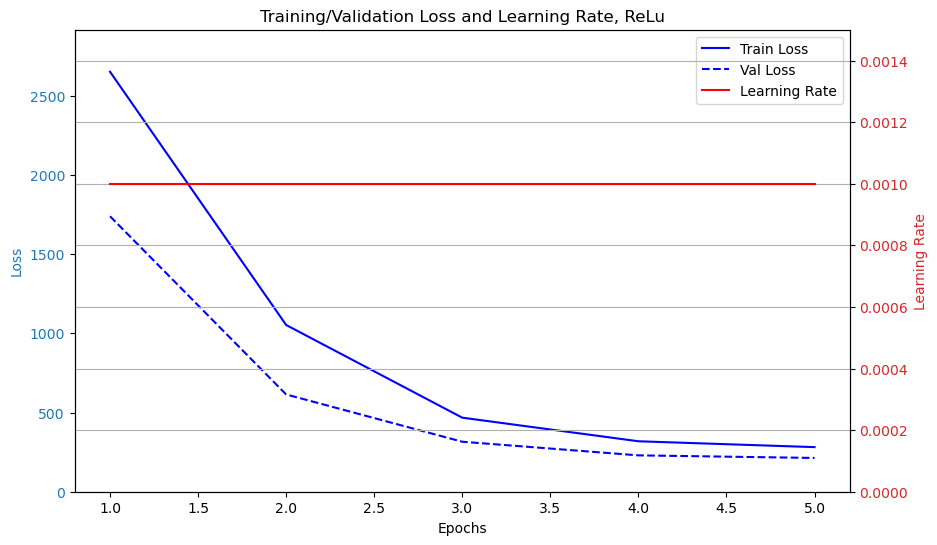

In [777]:
epochs = np.arange(1, len(history['train_loss']) + 1)

# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# График loss на первой оси (левая)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

# Вторая ось для learning rate (правая)
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)

# Легенда и заголовок
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, ReLu')
plt.grid(True)
plt.show()

In [779]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=32, n_layers=1, 
                                activation=LeakyReLU, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)

  0%|          | 0/563 [00:00<?, ?it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
100%|██████████| 563/563 [00:00<00:00, 3920.63it/s]


Epoch 1/5 - Train Loss: 2693.7410 - Val Loss: 1838.5374


100%|██████████| 563/563 [00:00<00:00, 3682.35it/s]


Epoch 2/5 - Train Loss: 1095.3660 - Val Loss: 580.3351


100%|██████████| 563/563 [00:00<00:00, 3708.40it/s]


Epoch 3/5 - Train Loss: 393.0683 - Val Loss: 215.4424


100%|██████████| 563/563 [00:00<00:00, 3809.45it/s]


Epoch 4/5 - Train Loss: 250.6294 - Val Loss: 165.4854


100%|██████████| 563/563 [00:00<00:00, 3759.25it/s]

Epoch 5/5 - Train Loss: 243.9572 - Val Loss: 172.2883


In [781]:
test_results

{'loss': 172.47095361948737,
 'predictions': array([[  59.7089764 ,  -59.79126701, -102.70306767],
        [  64.48628292,  -34.53611874,   60.4657323 ],
        [  81.59083551,   -4.76787458,   13.5645229 ],
        ...,
        [ 239.84947481,  -45.12142238,  -46.91217703],
        [  92.60380031,   -5.97142743,   15.96620515],
        [  36.71730852,   16.90418123,    1.31346353]])}

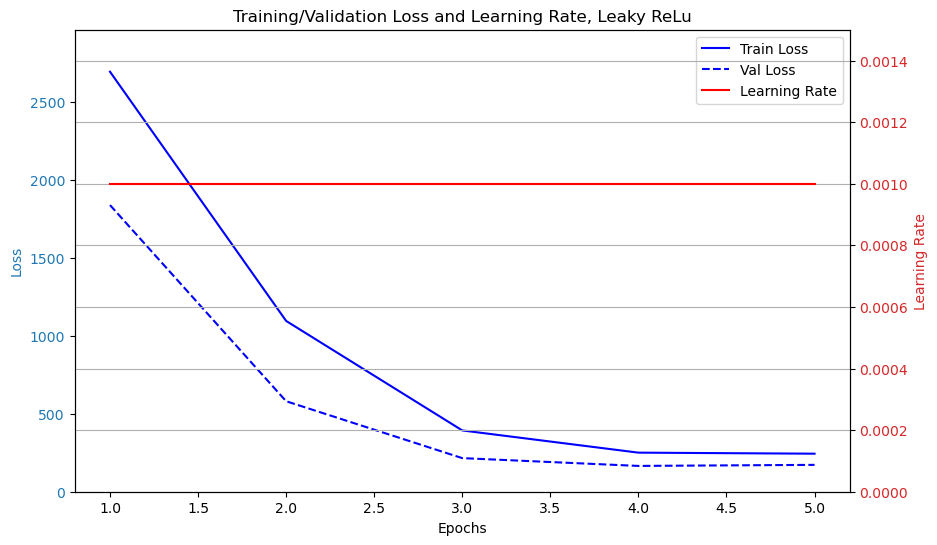

In [783]:
epochs = np.arange(1, len(history['train_loss']) + 1)

# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# График loss на первой оси (левая)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

# Вторая ось для learning rate (правая)
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)

# Легенда и заголовок
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, Leaky ReLu')
plt.grid(True)
plt.show()

In [785]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=32, n_layers=1, 
                                activation=SoftPlus, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)

  0%|          | 0/563 [00:00<?, ?it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
100%|██████████| 563/563 [00:00<00:00, 3535.36it/s]


Epoch 1/5 - Train Loss: 2598.2011 - Val Loss: 1780.7243


100%|██████████| 563/563 [00:00<00:00, 3441.53it/s]


Epoch 2/5 - Train Loss: 1089.9114 - Val Loss: 645.5642


100%|██████████| 563/563 [00:00<00:00, 3475.43it/s]


Epoch 3/5 - Train Loss: 498.0247 - Val Loss: 338.4347


100%|██████████| 563/563 [00:00<00:00, 3828.72it/s]


Epoch 4/5 - Train Loss: 320.0472 - Val Loss: 219.5454


100%|██████████| 563/563 [00:00<00:00, 3345.98it/s]


Epoch 5/5 - Train Loss: 266.3401 - Val Loss: 199.2556


In [787]:
test_results

{'loss': 200.0862786399334,
 'predictions': array([[ 5.70147805e+01, -4.06552611e+01, -6.66585608e+01],
        [ 6.77844383e+01, -3.56728021e+01,  5.66532110e+01],
        [ 8.16848907e+01,  7.40118237e-02,  2.08457740e+01],
        ...,
        [ 2.15952848e+02, -4.39351834e+01,  9.66578390e+00],
        [ 9.85413115e+01,  9.46425162e+00,  2.03967478e+01],
        [ 4.07407766e+01,  1.00073377e+01,  9.36925450e+00]])}

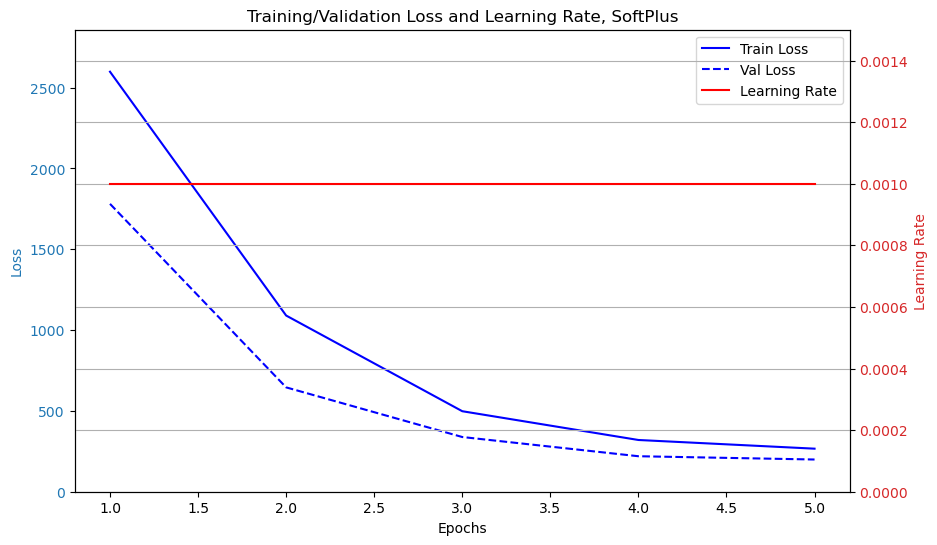

In [789]:
epochs = np.arange(1, len(history['train_loss']) + 1)

# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# График loss на первой оси (левая)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

# Вторая ось для learning rate (правая)
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)

# Легенда и заголовок
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, SoftPlus')
plt.grid(True)
plt.show()

In [791]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=32, n_layers=1, 
                                activation=ELU, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)

  0%|          | 0/563 [00:00<?, ?it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
100%|██████████| 563/563 [00:00<00:00, 3391.06it/s]


Epoch 1/5 - Train Loss: 2716.2286 - Val Loss: 1954.8630


100%|██████████| 563/563 [00:00<00:00, 3260.03it/s]


Epoch 2/5 - Train Loss: 1213.5913 - Val Loss: 704.7857


100%|██████████| 563/563 [00:00<00:00, 3411.61it/s]


Epoch 3/5 - Train Loss: 475.5636 - Val Loss: 294.4696


100%|██████████| 563/563 [00:00<00:00, 3277.36it/s]

Epoch 4/5 - Train Loss: 272.9449 - Val Loss: 182.8689



100%|██████████| 563/563 [00:00<00:00, 3275.89it/s]


Epoch 5/5 - Train Loss: 244.1536 - Val Loss: 183.2874


In [793]:
test_results

{'loss': 179.36912388385593,
 'predictions': array([[  54.86878594,  -40.54942008, -103.77422048],
        [  22.91536103,  -11.43649479,   18.15249246],
        [  79.25876198,  -10.96197432,   22.36049578],
        ...,
        [ 173.35207147,  -61.33142806,    7.03247936],
        [  94.02164159,   -7.76057172,   15.97066942],
        [  27.98898414,   17.7670766 ,  -14.27070694]])}

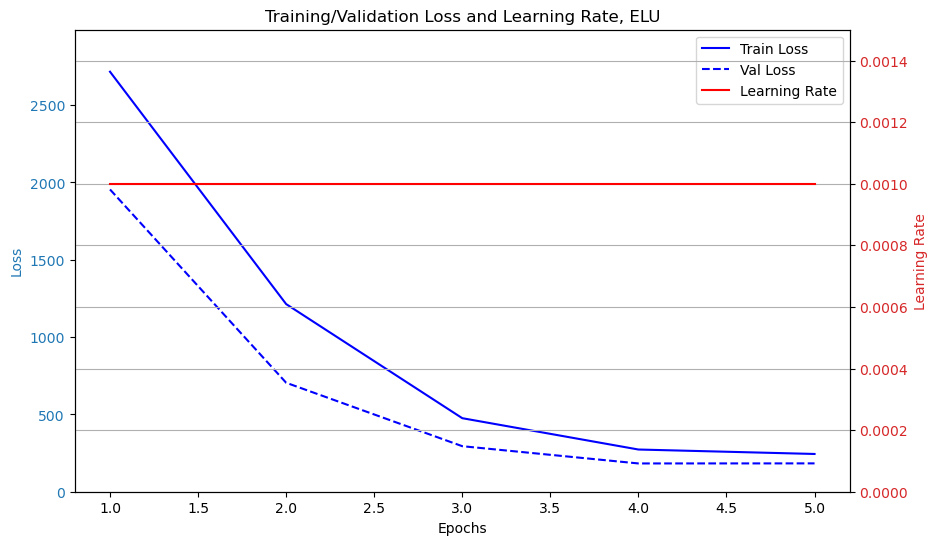

In [797]:
epochs = np.arange(1, len(history['train_loss']) + 1)

# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# График loss на первой оси (левая)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

# Вторая ось для learning rate (правая)
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)

# Легенда и заголовок
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, ELU')
plt.grid(True)
plt.show()

In [799]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=32, n_layers=1, 
                                activation=Gelu, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)

  0%|          | 0/563 [00:00<?, ?it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
100%|██████████| 563/563 [00:00<00:00, 2340.39it/s]


Epoch 1/5 - Train Loss: 2799.3501 - Val Loss: 2072.0319


100%|██████████| 563/563 [00:00<00:00, 2509.63it/s]


Epoch 2/5 - Train Loss: 1353.2825 - Val Loss: 854.4503


100%|██████████| 563/563 [00:00<00:00, 2407.54it/s]


Epoch 3/5 - Train Loss: 605.1530 - Val Loss: 403.9378


100%|██████████| 563/563 [00:00<00:00, 2435.47it/s]


Epoch 4/5 - Train Loss: 357.0992 - Val Loss: 259.1293


100%|██████████| 563/563 [00:00<00:00, 2415.99it/s]

Epoch 5/5 - Train Loss: 302.8716 - Val Loss: 237.6296


In [801]:
test_results

{'loss': 233.5481233672556,
 'predictions': array([[ 46.94441731, -73.04301359, -88.13120469],
        [ 27.2600528 ,  -4.88222679,  20.82389555],
        [ 96.36508018,  10.42410179,  10.22608296],
        ...,
        [247.57448194, -40.29310615, -11.77924598],
        [ 84.89368193, -19.3300476 ,  10.12278371],
        [ 46.93018546,  12.99935324,  -4.87710825]])}

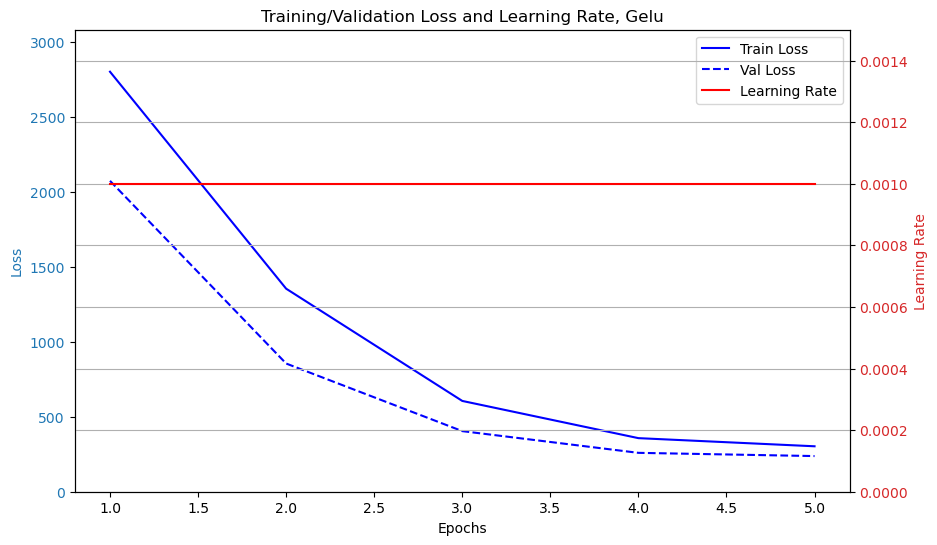

In [803]:
epochs = np.arange(1, len(history['train_loss']) + 1)

# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# График loss на первой оси (левая)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

# Вторая ось для learning rate (правая)
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)

# Легенда и заголовок
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, Gelu')
plt.grid(True)
plt.show()

Лучшая метрика здесь у LeakyRelu

#### Мультирегрессия, средняя модель

In [876]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=128, n_layers=3,
                       activation = ReLU, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)
test_results

  9%|▊         | 48/563 [00:00<00:01, 479.30it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
100%|██████████| 563/563 [00:00<00:00, 575.85it/s]


Epoch 1/5 - Train Loss: 1863.8104 - Val Loss: 580.0570


100%|██████████| 563/563 [00:00<00:00, 610.28it/s]


Epoch 2/5 - Train Loss: 359.2520 - Val Loss: 208.8299


100%|██████████| 563/563 [00:00<00:00, 591.90it/s]


Epoch 3/5 - Train Loss: 269.8583 - Val Loss: 210.4789


100%|██████████| 563/563 [00:01<00:00, 558.01it/s]


Epoch 4/5 - Train Loss: 282.7528 - Val Loss: 223.7205


100%|██████████| 563/563 [00:00<00:00, 608.88it/s]


Epoch 5/5 - Train Loss: 305.5698 - Val Loss: 263.4420


{'loss': 218.27180752760978,
 'predictions': array([[ 61.02089149, -40.77192198, -65.32646373],
        [ 56.23358306, -38.75292591,  51.93216831],
        [ 67.11548769,   1.07228178,  11.88632659],
        ...,
        [180.51725226, -33.84882144,  21.71786338],
        [ 97.48185297,  -5.82804671,  14.80859801],
        [ 38.34569617,   9.50136277,   6.78860252]])}

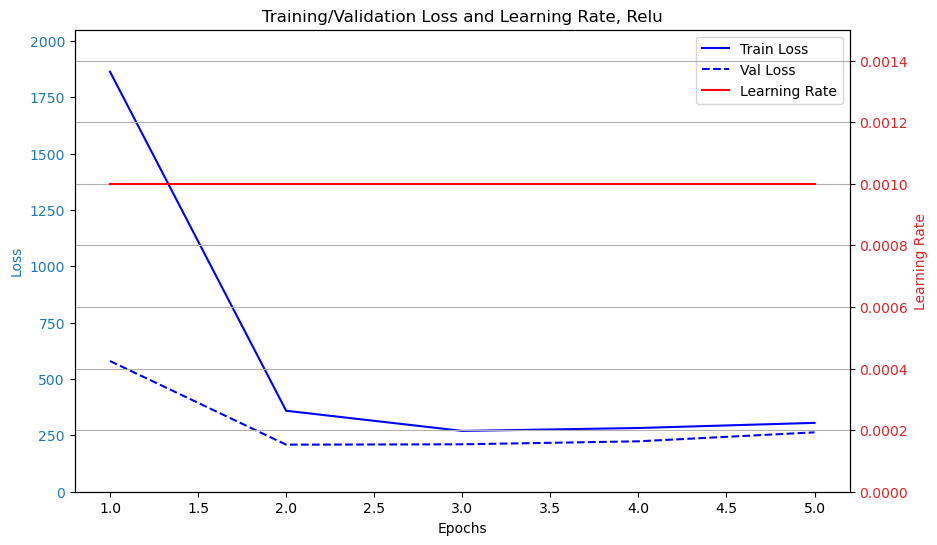

In [878]:
epochs = np.arange(1, len(history['train_loss']) + 1)

# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# График loss на первой оси (левая)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

# Вторая ось для learning rate (правая)
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)

# Легенда и заголовок
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, Relu')
plt.grid(True)
plt.show()

In [880]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=128, n_layers=3,
                       activation = LeakyReLU, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)
test_results

 12%|█▏        | 66/563 [00:00<00:00, 574.04it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
100%|██████████| 563/563 [00:00<00:00, 594.11it/s]


Epoch 1/5 - Train Loss: 1973.6342 - Val Loss: 613.6310


100%|██████████| 563/563 [00:00<00:00, 577.64it/s]


Epoch 2/5 - Train Loss: 303.9235 - Val Loss: 155.5877


100%|██████████| 563/563 [00:00<00:00, 591.47it/s]


Epoch 3/5 - Train Loss: 229.0717 - Val Loss: 163.7455


100%|██████████| 563/563 [00:01<00:00, 562.57it/s]


Epoch 4/5 - Train Loss: 237.3798 - Val Loss: 177.3938


100%|██████████| 563/563 [00:01<00:00, 555.84it/s]


Epoch 5/5 - Train Loss: 251.4472 - Val Loss: 190.4533


{'loss': 146.45073995596002,
 'predictions': array([[  29.55307365,  -67.29014588, -108.30184483],
        [  33.92945005,  -21.54935054,   68.09795376],
        [  93.8664475 ,   21.40691461,   26.77419671],
        ...,
        [ 211.46261687,  -30.4955437 ,   -9.28680541],
        [  77.12552153,  -20.80466177,    2.19547043],
        [  37.02012919,   12.38946757,   -4.14805537]])}

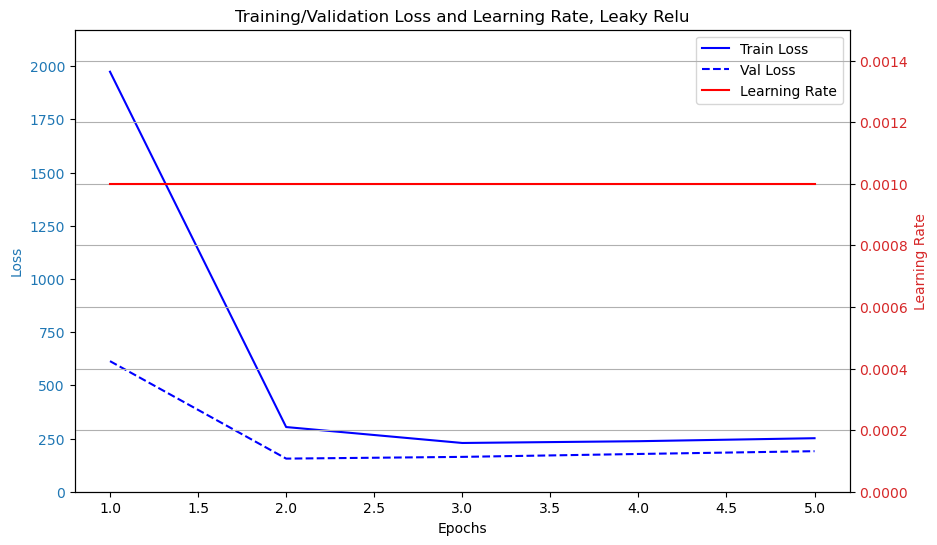

In [882]:
epochs = np.arange(1, len(history['train_loss']) + 1)

# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# График loss на первой оси (левая)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

# Вторая ось для learning rate (правая)
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)

# Легенда и заголовок
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, Leaky Relu')
plt.grid(True)
plt.show()

In [884]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=128, n_layers=3,
                       activation = SoftPlus, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)
test_results

  8%|▊         | 47/563 [00:00<00:01, 469.36it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
100%|██████████| 563/563 [00:01<00:00, 495.20it/s]


Epoch 1/5 - Train Loss: 1809.0077 - Val Loss: 939.8484


100%|██████████| 563/563 [00:01<00:00, 504.12it/s]


Epoch 2/5 - Train Loss: 824.0399 - Val Loss: 614.7761


100%|██████████| 563/563 [00:01<00:00, 489.87it/s]


Epoch 3/5 - Train Loss: 429.5026 - Val Loss: 272.0709


100%|██████████| 563/563 [00:01<00:00, 446.62it/s]


Epoch 4/5 - Train Loss: 307.3494 - Val Loss: 238.2947


100%|██████████| 563/563 [00:01<00:00, 456.93it/s]


Epoch 5/5 - Train Loss: 305.4799 - Val Loss: 243.7263


{'loss': 237.01056384534374,
 'predictions': array([[ 45.41361636, -42.3070728 , -48.5505198 ],
        [ 52.58937062, -33.81871401,  38.83227067],
        [102.11230767,  22.27333484,  43.44717129],
        ...,
        [177.81083034, -40.19720549,  13.4222693 ],
        [ 90.67202391, -20.37765283,  -3.37953018],
        [ 25.26011465,   6.87513127,   7.34731888]])}

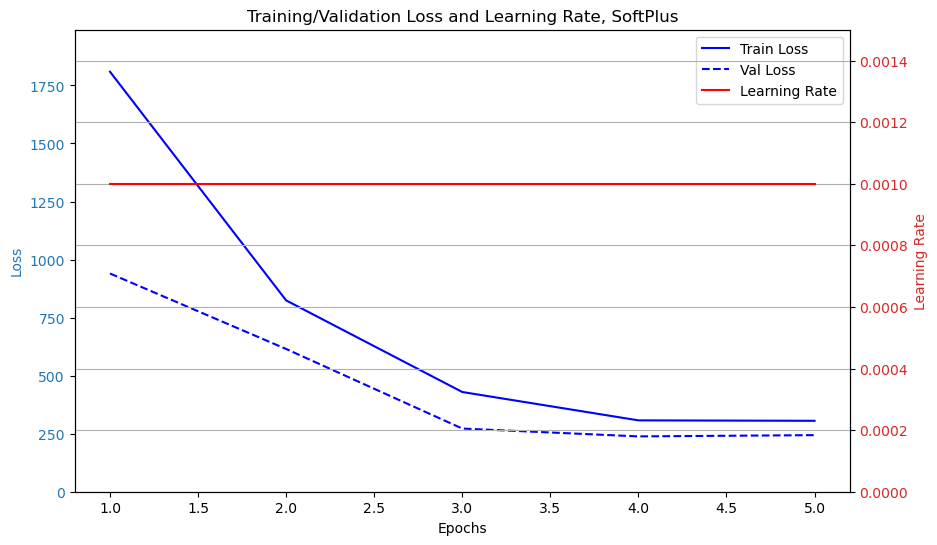

In [886]:
epochs = np.arange(1, len(history['train_loss']) + 1)

# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# График loss на первой оси (левая)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

# Вторая ось для learning rate (правая)
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)

# Легенда и заголовок
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, SoftPlus')
plt.grid(True)
plt.show()

In [888]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=128, n_layers=3,
                       activation = ELU, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)
test_results

  9%|▉         | 52/563 [00:00<00:00, 516.71it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
100%|██████████| 563/563 [00:01<00:00, 543.30it/s]


Epoch 1/5 - Train Loss: 1908.1828 - Val Loss: 613.6888


100%|██████████| 563/563 [00:01<00:00, 555.64it/s]


Epoch 2/5 - Train Loss: 312.0792 - Val Loss: 114.6829


100%|██████████| 563/563 [00:01<00:00, 555.78it/s]


Epoch 3/5 - Train Loss: 184.7952 - Val Loss: 114.9455


100%|██████████| 563/563 [00:01<00:00, 533.87it/s]


Epoch 4/5 - Train Loss: 193.7951 - Val Loss: 121.6802


100%|██████████| 563/563 [00:01<00:00, 536.96it/s]


Epoch 5/5 - Train Loss: 203.3530 - Val Loss: 138.5221


{'loss': 111.47781487571021,
 'predictions': array([[ 54.00698786, -39.58846237, -72.19655201],
        [ 49.08392708, -27.5105269 ,  53.44800903],
        [ 76.44998526,   8.85803115,  24.98396806],
        ...,
        [159.61847567, -70.79471512,  -5.43260405],
        [ 74.88288425,  -5.74589003,   1.23538648],
        [ 32.12613277,  23.53808882,   8.16111001]])}

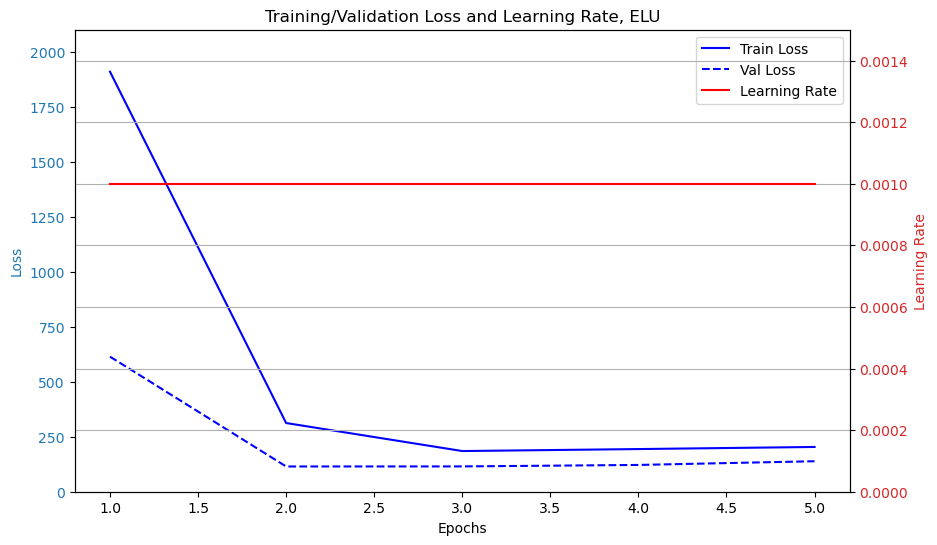

In [890]:
epochs = np.arange(1, len(history['train_loss']) + 1)

# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# График loss на первой оси (левая)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

# Вторая ось для learning rate (правая)
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)

# Легенда и заголовок
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, ELU')
plt.grid(True)
plt.show()

In [892]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=128, n_layers=3,
                       activation = Gelu, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)
test_results

 12%|█▏        | 65/563 [00:00<00:01, 302.80it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
100%|██████████| 563/563 [00:01<00:00, 305.77it/s]


Epoch 1/5 - Train Loss: 2067.8333 - Val Loss: 737.9727


100%|██████████| 563/563 [00:01<00:00, 302.32it/s]


Epoch 2/5 - Train Loss: 370.3227 - Val Loss: 139.8720


100%|██████████| 563/563 [00:01<00:00, 311.64it/s]


Epoch 3/5 - Train Loss: 192.3443 - Val Loss: 118.1675


100%|██████████| 563/563 [00:01<00:00, 311.92it/s]


Epoch 4/5 - Train Loss: 193.5622 - Val Loss: 131.0408


100%|██████████| 563/563 [00:02<00:00, 281.14it/s]


Epoch 5/5 - Train Loss: 202.4232 - Val Loss: 134.9004


{'loss': 116.8235432870311,
 'predictions': array([[ 77.52834958, -47.71541028, -55.80379263],
        [ 43.85280462, -33.73270255,  45.23222052],
        [ 80.61164721,   1.58231724,  26.49456047],
        ...,
        [211.97138512, -56.79123592, -30.18228264],
        [ 91.83310553,   3.33729848,  24.6302571 ],
        [ 39.37190504,  14.36435649, -13.47003104]])}

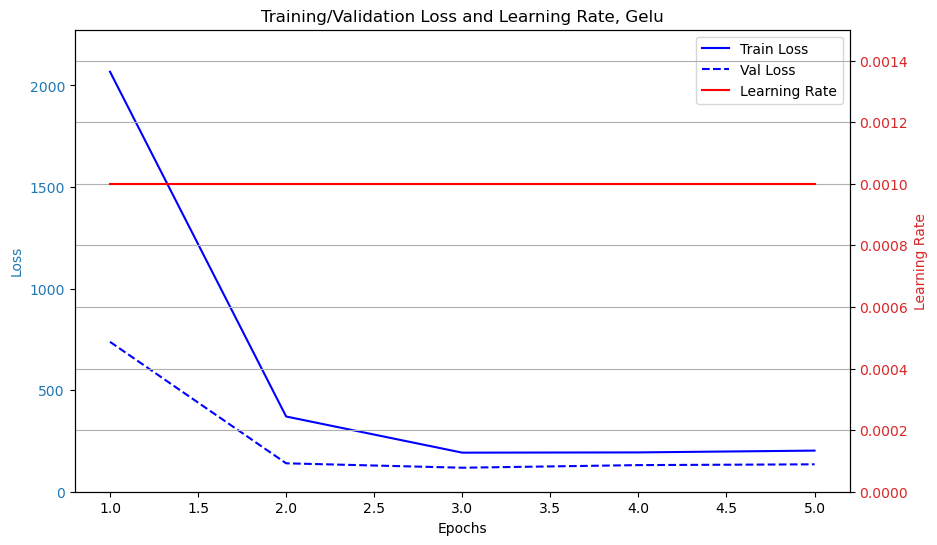

In [894]:
epochs = np.arange(1, len(history['train_loss']) + 1)

# Создаем фигуру с двумя осями Y
fig, ax1 = plt.subplots(figsize=(10, 6))

# График loss на первой оси (левая)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

# Вторая ось для learning rate (правая)
ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)

# Легенда и заголовок
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, Gelu')
plt.grid(True)
plt.show()

Здесь лучшая метрика у ELU, причем с добавлением dropout ситуация ухудшается - loss заметно растет (в 10 раз)

#### Мультирегрессия, большая модель

In [898]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=512, n_layers=5,
                       activation = ReLU, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)
test_results

 10%|▉         | 55/563 [00:02<00:19, 26.31it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
100%|██████████| 563/563 [00:22<00:00, 25.34it/s]


Epoch 1/5 - Train Loss: 1192.5498 - Val Loss: 182.6941


100%|██████████| 563/563 [00:22<00:00, 24.98it/s]


Epoch 2/5 - Train Loss: 247.5821 - Val Loss: 183.0199


100%|██████████| 563/563 [00:22<00:00, 25.36it/s]


Epoch 3/5 - Train Loss: 297.6713 - Val Loss: 292.1464


100%|██████████| 563/563 [00:22<00:00, 24.90it/s]


Epoch 4/5 - Train Loss: 382.9777 - Val Loss: 351.8282


100%|██████████| 563/563 [00:23<00:00, 24.16it/s]


Epoch 5/5 - Train Loss: 470.6244 - Val Loss: 485.2528


{'loss': 183.28684781767805,
 'predictions': array([[ 5.15300785e+01, -4.40624203e+01, -6.60749367e+01],
        [ 7.06090090e+01, -4.08734535e+01,  5.57285900e+01],
        [ 7.90536180e+01, -1.01303646e+01,  1.42097644e+01],
        ...,
        [ 1.89975427e+02, -3.70320142e+01, -3.05068582e+01],
        [ 7.92113634e+01, -2.75279075e-02,  1.42271692e+01],
        [ 4.10592590e+01,  8.07020440e+00,  4.50972533e+00]])}

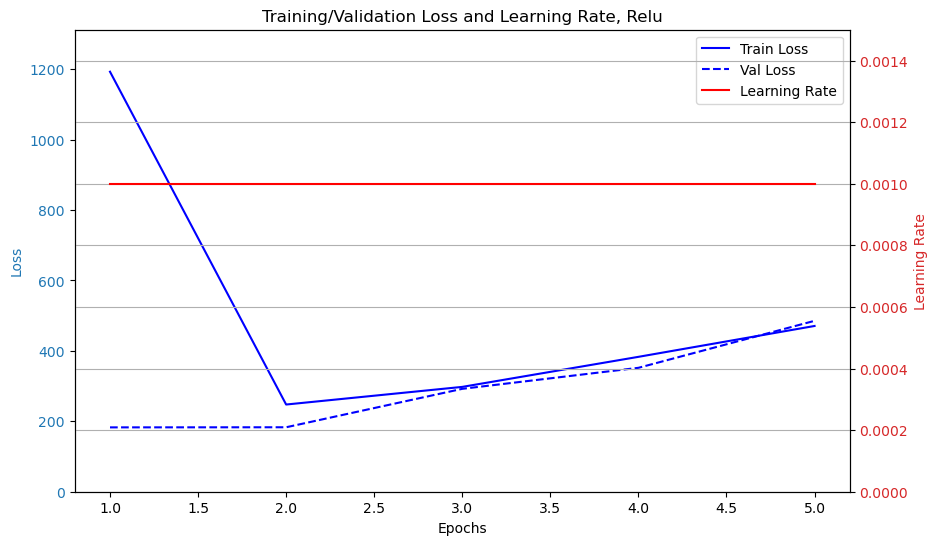

In [900]:
epochs = np.arange(1, len(history['train_loss']) + 1)


fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)


ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, Relu')
plt.grid(True)
plt.show()

In [904]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=512, n_layers=5,
                       activation = LeakyReLU, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)
test_results

 10%|█         | 57/563 [00:02<00:18, 26.94it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
100%|██████████| 563/563 [00:25<00:00, 22.24it/s]


Epoch 1/5 - Train Loss: 1140.9315 - Val Loss: 123.2398


100%|██████████| 563/563 [00:27<00:00, 20.53it/s]


Epoch 2/5 - Train Loss: 213.9079 - Val Loss: 152.7029


100%|██████████| 563/563 [00:26<00:00, 21.00it/s]


Epoch 3/5 - Train Loss: 247.5547 - Val Loss: 196.2945


100%|██████████| 563/563 [00:28<00:00, 19.97it/s]


Epoch 4/5 - Train Loss: 291.2842 - Val Loss: 257.6238


100%|██████████| 563/563 [00:26<00:00, 21.46it/s]


Epoch 5/5 - Train Loss: 328.4928 - Val Loss: 275.0960


{'loss': 117.52120088828073,
 'predictions': array([[ 15.76530639, -43.1994247 , -77.24055041],
        [ 60.16641325, -25.29486095,  71.16424275],
        [ 87.79969407,  -2.25810014,  18.51892837],
        ...,
        [187.11247479, -36.00584056,  16.03852824],
        [ 79.71652785,  -7.98339485,  12.74229828],
        [ 25.62095744,  13.59418917,   4.75518887]])}

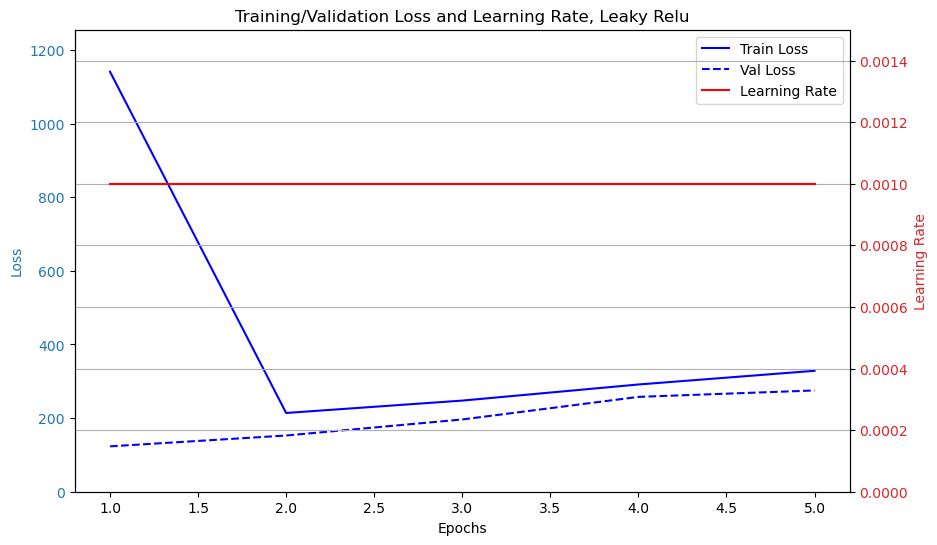

In [906]:
epochs = np.arange(1, len(history['train_loss']) + 1)


fig, ax1 = plt.subplots(figsize=(10, 6))

# График loss на первой оси (левая)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)


ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, Leaky Relu')
plt.grid(True)
plt.show()

In [910]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=512, n_layers=5,
                       activation = SoftPlus, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)
test_results

 10%|█         | 57/563 [00:02<00:20, 24.83it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
100%|██████████| 563/563 [00:26<00:00, 21.05it/s]


Epoch 1/5 - Train Loss: 1377.4527 - Val Loss: 926.2589


100%|██████████| 563/563 [00:27<00:00, 20.12it/s]


Epoch 2/5 - Train Loss: 889.0528 - Val Loss: 863.3254


100%|██████████| 563/563 [00:27<00:00, 20.26it/s]


Epoch 3/5 - Train Loss: 867.8988 - Val Loss: 856.8507


100%|██████████| 563/563 [00:28<00:00, 19.92it/s]


Epoch 4/5 - Train Loss: 867.3870 - Val Loss: 858.6765


100%|██████████| 563/563 [00:27<00:00, 20.19it/s]


Epoch 5/5 - Train Loss: 722.4616 - Val Loss: 550.3721


{'loss': 539.8489746745314,
 'predictions': array([[ 57.65278861, -57.08805256, -68.6798538 ],
        [ 74.49053622,  -2.23710865,  51.98196895],
        [ 84.90504261, -18.86383138,  22.33213287],
        ...,
        [192.05817176, -64.88165199, -20.51496146],
        [ 75.18885163, -18.99581523,  11.14337062],
        [ 41.72269491,  -7.16577075,  20.06118991]])}

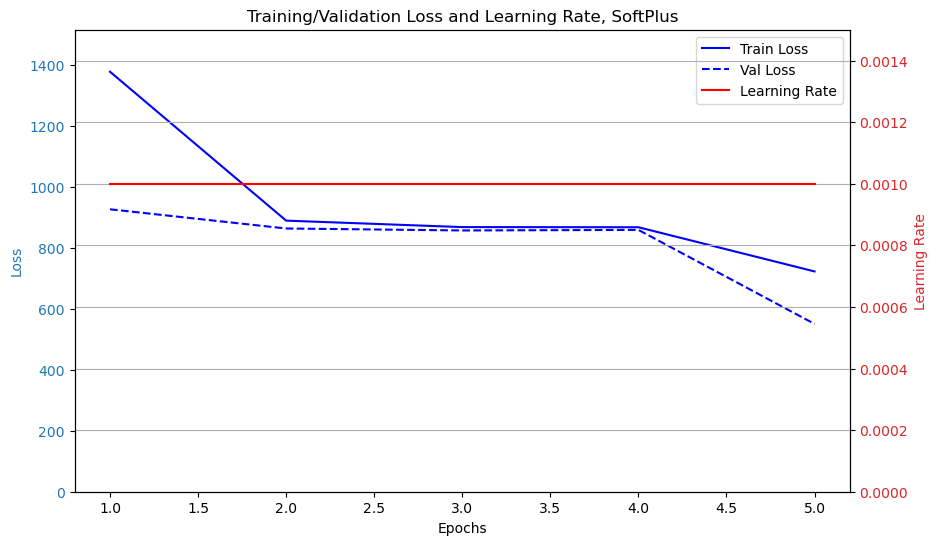

In [912]:
epochs = np.arange(1, len(history['train_loss']) + 1)


fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)


ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, SoftPlus')
plt.grid(True)
plt.show()

In [914]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=512, n_layers=5,
                       activation = ELU, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)
test_results

 10%|█         | 57/563 [00:02<00:19, 26.28it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
100%|██████████| 563/563 [00:24<00:00, 23.16it/s]


Epoch 1/5 - Train Loss: 1054.6015 - Val Loss: 74.3433


100%|██████████| 563/563 [00:28<00:00, 20.00it/s]


Epoch 2/5 - Train Loss: 157.5586 - Val Loss: 90.8877


100%|██████████| 563/563 [00:29<00:00, 19.00it/s]


Epoch 3/5 - Train Loss: 182.4566 - Val Loss: 119.9323


100%|██████████| 563/563 [00:29<00:00, 19.00it/s]


Epoch 4/5 - Train Loss: 210.3958 - Val Loss: 152.9046


100%|██████████| 563/563 [00:30<00:00, 18.45it/s]


Epoch 5/5 - Train Loss: 232.1486 - Val Loss: 173.1974


{'loss': 73.92981409200029,
 'predictions': array([[ 65.08499897, -58.50199968, -80.44912279],
        [ 56.89950943, -33.4665032 ,  64.03749289],
        [ 64.8234236 ,   5.75868888,  18.84877328],
        ...,
        [178.17406583, -54.28649514, -10.17419073],
        [ 91.63074708,  -7.58640766,   8.03384606],
        [ 26.40590125,   8.56470959,  15.56436421]])}

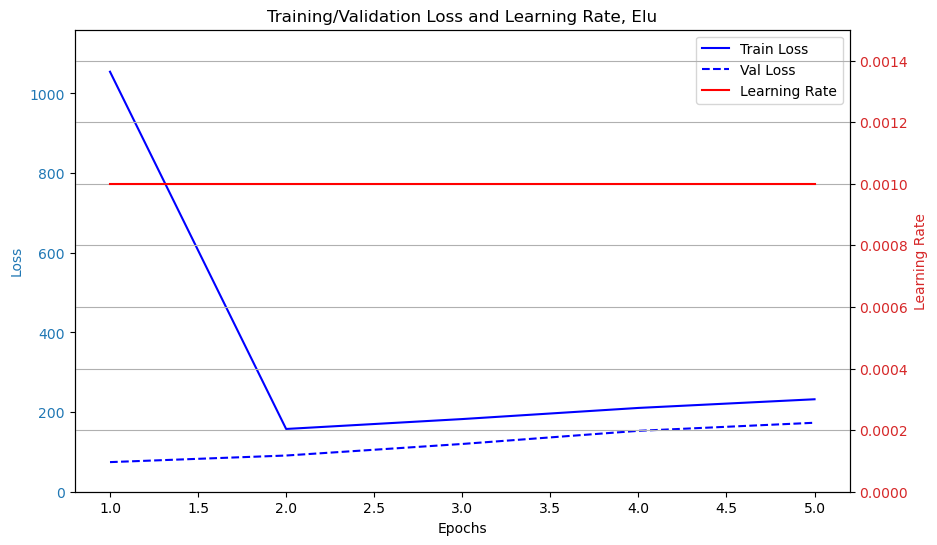

In [916]:
epochs = np.arange(1, len(history['train_loss']) + 1)


fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)


ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, Elu')
plt.grid(True)
plt.show()

In [918]:
model = create_regression_model(n_features=9, n_targets=3, hidden_size=512, n_layers=5,
                       activation = Gelu, dropout_p = 0.3)
optimizer = Adam(lr=0.001)
trained_model, history = train_regression_model(
     model, X_train, y_train, X_val, y_val, optimizer, epochs=5
)
test_results = evaluate_regression_model(trained_model, X_test, y_test)
test_results

 10%|▉         | 56/563 [00:02<00:25, 20.24it/s]C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * mean
C:\Users\teria\AppData\Local\Temp\ipykernel_17580\4134660126.py:22: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * var
100%|██████████| 563/563 [00:30<00:00, 18.35it/s]


Epoch 1/5 - Train Loss: 1287.4215 - Val Loss: 101.5849


100%|██████████| 563/563 [00:34<00:00, 16.28it/s]


Epoch 2/5 - Train Loss: 157.8074 - Val Loss: 77.9154


100%|██████████| 563/563 [00:33<00:00, 17.00it/s]


Epoch 3/5 - Train Loss: 158.6193 - Val Loss: 89.9382


100%|██████████| 563/563 [00:32<00:00, 17.15it/s]


Epoch 4/5 - Train Loss: 160.3898 - Val Loss: 91.2374


100%|██████████| 563/563 [00:33<00:00, 17.02it/s]


Epoch 5/5 - Train Loss: 165.9363 - Val Loss: 106.6548


{'loss': 78.77120427932307,
 'predictions': array([[ 33.46094155, -33.59078553, -90.9368363 ],
        [ 59.76885056, -40.66671592,  47.427651  ],
        [ 79.29800624,  -2.02916507,   9.71474041],
        ...,
        [201.37177394, -34.16985227, -12.52080924],
        [ 85.4035726 ,  -9.97789253,  11.68910927],
        [ 42.63178552,  15.2605462 ,   4.7191453 ]])}

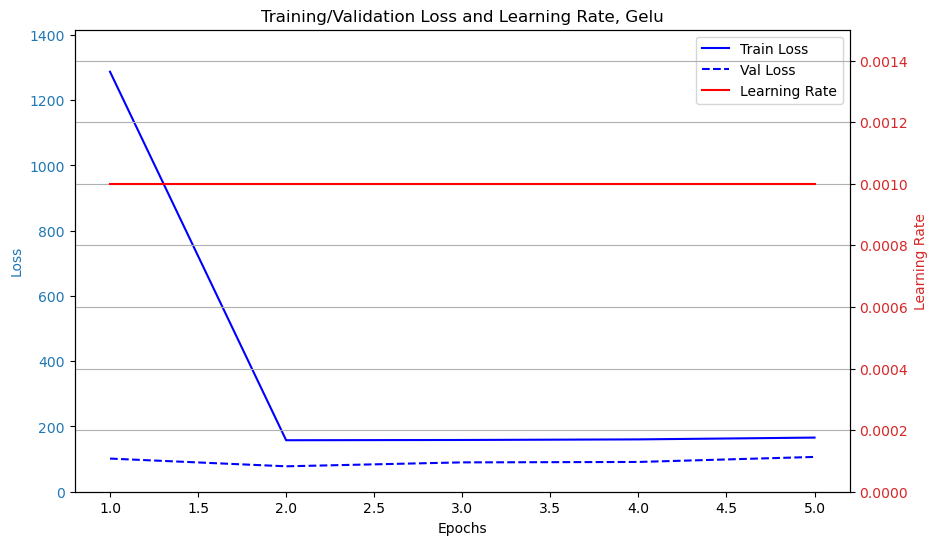

In [922]:
epochs = np.arange(1, len(history['train_loss']) + 1)


fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['val_loss'], 'b--', label='Val Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)


ax2 = ax1.twinx()
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.plot(epochs, history['lr'], 'r-', label='Learning Rate')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(history['lr']) * 1.5)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Training/Validation Loss and Learning Rate, Gelu')
plt.grid(True)
plt.show()

Вновь лучшие результаты у ELU. Т.е. при средней и большой модели использование ELU дает наименьший loss на тесте, а при малой модели наименьший лосс дает использование Leaky RELU. Добавление dropout ухудшает лосс, однако позволяет избегать переобучения моделей. Выбирала mse, т.к. это классическая метрика для задач регрессии и она дифференцируема, что удобно для оптимизации.


### Автоэнкодер MNIST

Выбираем метрику MSE для реконструкции, так как она хорошо работает с задачей реконструкции, чувствительна к различиям в пикселях, дифференцируема

In [1025]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype('float32') / 255.0
X = X.values.reshape(-1, 28, 28, 1) 


indices = np.random.choice(len(X), size=1000, replace=False)
X_small = X[indices]
X_train, X_test = X_small[:700], X_small[300:]


In [995]:
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()
    
    def updateOutput(self, input):
        self.output = 1.0 / (1.0 + np.exp(-input))
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        
        sigmoid_output = self.output
        self.gradInput = gradOutput * (sigmoid_output * (1 - sigmoid_output))
        return self.gradInput
    
    def __repr__(self):
        return "Sigmoid()"


class Upsampling2d(Module):
    def __init__(self, scale_factor=2):
        super(Upsampling2d, self).__init__()
        self.scale_factor = scale_factor
    
    def updateOutput(self, input):
        """
        Простая реализация апсемплинга через повторение элементов
        input: тензор формы (batch_size, channels, height, width)
        """
        batch_size, channels, height, width = input.shape
        self.output = np.repeat(input, self.scale_factor, axis=2)  # Повторяем по высоте
        self.output = np.repeat(self.output, self.scale_factor, axis=3)  # Повторяем по ширине
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        """
        Обратное распространение для апсемплинга
        Просто суммируем градиенты по всем повторенным элементам
        """
        batch_size, channels, height, width = input.shape
        gradInput = np.zeros_like(input)
        
        
        for i in range(self.scale_factor):
            for j in range(self.scale_factor):
                gradInput += gradOutput[:, :, i::self.scale_factor, j::self.scale_factor]
        
        self.gradInput = gradInput
        return self.gradInput
    
    def __repr__(self):
        return f"Upsampling2d(scale_factor={self.scale_factor})"


        
class Reshape(Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
    
    def updateOutput(self, input):
        self.output = input.reshape(input.shape[0], *self.shape)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(input.shape)
        return self.gradInput
    
    def __repr__(self):
        return f"Reshape({self.shape})"


class ConvAutoencoder:
    def __init__(self):
        
        self.encoder = Sequential()
        self.encoder.add(Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1))
        self.encoder.add(ReLU())
        self.encoder.add(MaxPool2d(kernel_size=2, stride=2))
        
        self.encoder.add(Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1))
        self.encoder.add(ReLU())
        self.encoder.add(MaxPool2d(kernel_size=2, stride=2))
        
        self.encoder.add(Flatten())
        self.encoder.add(Linear(8*7*7, 32))
        self.encoder.add(ReLU())
        
        
        self.decoder = Sequential()
        self.decoder.add(Linear(32, 8*7*7))
        self.decoder.add(ReLU())
        self.decoder.add(Reshape((8, 7, 7)))
        
        self.decoder.add(Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1))
        self.decoder.add(ReLU())
        self.decoder.add(Upsampling2d(scale_factor=2))
        
        self.decoder.add(Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1))
        self.decoder.add(ReLU())
        self.decoder.add(Upsampling2d(scale_factor=2))
        
        self.decoder.add(Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1))
        self.decoder.add(Sigmoid())
    
    def forward(self, x):
        
        self.input = x.copy() 
        
        
        if len(x.shape) == 3:  
            x = x[np.newaxis, ...]  
            
        encoded = self.encoder.forward(x)
        decoded = self.decoder.forward(encoded)
        return decoded
    
    def backward(self, grad_output):
        grad_decoder = self.decoder.backward(self.encoder.output, grad_output)
        
        self.encoder.backward(self.input, grad_decoder)
        return self.encoder.gradInput

In [1027]:
X_train = X_train.reshape(-1, 1, 28, 28)  
X_test = X_test.reshape(-1, 1, 28, 28)
epochs=5
autoencoder = ConvAutoencoder()
optimizer = Adam(lr=0.001)
loss_fn = MSECriterion()


for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        
        
        reconstructed = autoencoder.forward(batch)
        loss = loss_fn.forward(reconstructed, batch)
        
        
        grad_output = loss_fn.backward(reconstructed, batch)
        autoencoder.backward(grad_output)
        
        
        params = autoencoder.encoder.getParameters() + autoencoder.decoder.getParameters()
        grads = autoencoder.encoder.getGradParameters() + autoencoder.decoder.getGradParameters()
        
        optimizer.update(params, grads)
        
        
        autoencoder.encoder.zeroGradParameters()
        autoencoder.decoder.zeroGradParameters()
        
        epoch_loss += loss
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(X_train):.4f}")

C:\Users\teria\AppData\Local\Temp\ipykernel_17580\2513686913.py:6: RuntimeWarning: overflow encountered in exp
  self.output = 1.0 / (1.0 + np.exp(-input))


Epoch 1, Loss: 13.4917
Epoch 2, Loss: 9.2185
Epoch 3, Loss: 7.9140
Epoch 4, Loss: 7.6478
Epoch 5, Loss: 7.6286


Min/Max test_images: 0.0 1.0
Min/Max reconstructed_images: 0.0 1.0


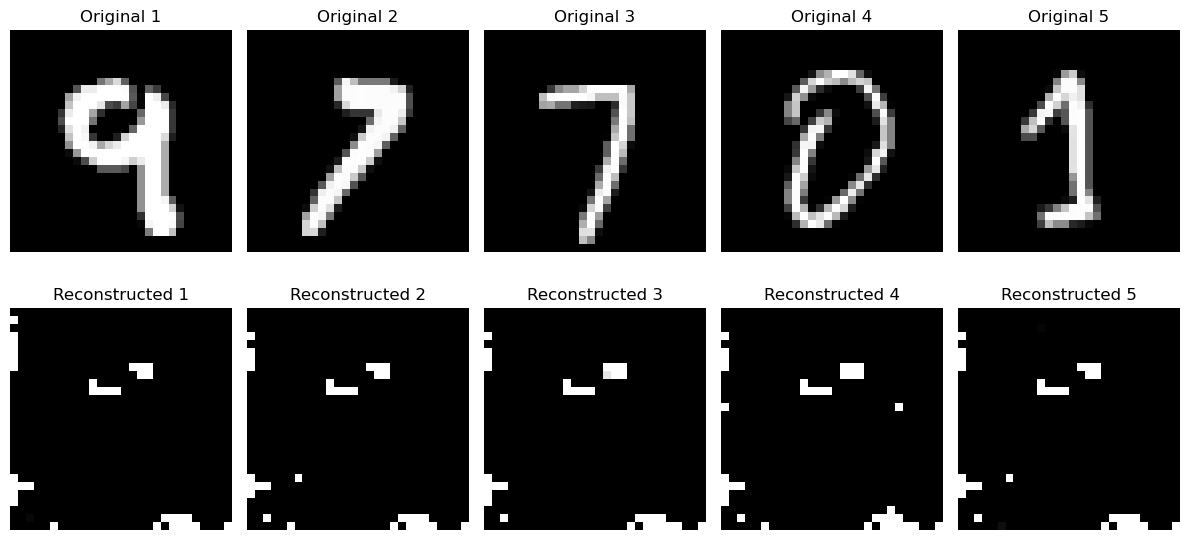

In [1029]:
def plot_results(original, reconstructed, n=5):
    plt.figure(figsize=(12, 6))  
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray') 
        plt.title(f"Original {i+1}")
        plt.axis('off')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title(f"Reconstructed {i+1}")
        plt.axis('off')
    
    plt.tight_layout() 
    plt.show()


print("Min/Max test_images:", test_images.min(), test_images.max())
print("Min/Max reconstructed_images:", reconstructed_images.min(), reconstructed_images.max())

plot_results(test_images, reconstructed_images)

мы видим, что уже появляется очертание 0 с точкой, при маленьких датасетах картинки реконструированные были почти одинаковыми, к сожалению, модель на большом количестве данных не получилось отрисовать в силу малых мощностей, однако мы видим, что автоэнкодер работает